In [1]:
import os
import sys
import numpy as np
import torch

from highd_utils.process_utils import *

In [2]:
options = {}
options['input_path'] = "./raw/highD-dataset-v1.0/data/"
options['track_files'] = "%02d_tracks.csv"
options['track_meta_files'] = "%02d_tracksMeta.csv"
options['rec_meta_files'] = "%02d_recordingMeta.csv"
options['min_track'] = 1 # min number to load
options['max_track'] = 5 #60 # max number to load
options['min_track_length'] = 200 # min track length
options['max_track_length'] = 350 # min track length
options['p_keep_straight'] = 0.0 # Probability to keep a straight car (0.0 = lane changes only, 1.0 = full dataset)
options['frame_rate'] = 4 # Keep every nth frame. Note recorded frame rate is 25 Hz
options['locations'] = [1,2,3,4,5,6]
options['features'] = ['x','y','dhw','thw']
options['randseed'] = 1
options['output_dir'] = "./processed/"
options['output_file'] = "highd_processed_tracks%02d-%02d_fr%02d_loc%s_p%3.2f.pt" %(
    options['min_track'],options['max_track'], 
    options['frame_rate'], "".join([str(i) for i in options['locations']]), 
    options['p_keep_straight'])

In [ ]:
all_tracks, all_static, all_rec = read_all_data(options)

Loading track 01 in 01 : 05.
Removing 913 out of 1048 frames.
Loading track 02 in 01 : 05.
Removing 994 out of 1114 frames.
Loading track 03 in 01 : 05.


In [4]:
combine = combine_data(all_tracks, options)

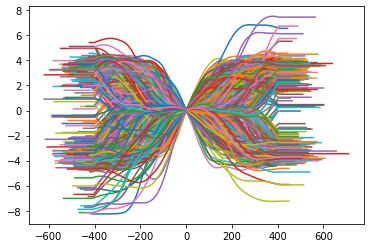

In [10]:
import matplotlib.pyplot as plt
plt.plot(combine['x'].T,combine['y'].T)
plt.show()

In [7]:
data_tensor = feature_dict_to_tensor(combine, options)
print(data_tensor.shape)
red_data_tensor = reduce_frame_rate(data_tensor, options)
print(red_data_tensor.shape)

torch.Size([350, 858, 4])
torch.Size([88, 858, 4])


In [8]:
save_tensor(red_data_tensor, options)

(array([  8.,  53., 182., 236., 169., 108.,  41.,  27.,  22.,  12.]),
 array([209. , 234.2, 259.4, 284.6, 309.8, 335. , 360.2, 385.4, 410.6,
        435.8, 461. ]),
 <a list of 10 Patch objects>)

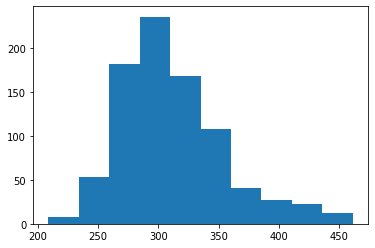

In [9]:
frames = []
for rec in all_static.keys():
    for car in all_static[rec].keys():
        frames.append(all_static[rec][car]['numFrames'])
        
plt.hist(frames) # based on this histogram, requiring a minimum of 200 frames